In [1]:
# !pip install plotly -U
# !pip install stqdm -U
# !pip install -U watermark

In [1]:
# import streamlit as st
import h5py
import numpy as np
from unet.unet import UNet1D
import torch
from utils import read_process_mat_file, sigmoid, split_given_size
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from stqdm import stqdm
from sklearn import metrics
# import streamlit.components.v1 as components
import base64
import json
import scipy
import os
from tqdm.notebook import tqdm
from scipy.spatial import distance
import torchaudio
from model import LightningModel

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
device

device(type='mps')

## Load Model

In [3]:
ckpt_path='./test_checkpoint/scale_0_1_epoch=26-val_loss=0.25-step=138807.00.ckpt'
model = UNet1D(
        normalization='batch',
        preactivation=False,
        residual=True,
        out_classes=1,
        num_encoding_blocks=5,
        encoder_kernel_sizes=[5,5,5,5,5],
        decoder_kernel_sizes=[3]*4,
    )
model=LightningModel.load_from_checkpoint(ckpt_path, **{'model':model}).model
model = model.to(device)
model.eval()

def predict_whole_data(_model, _ecog_list, _label_list):
        preds=[]
        probs=[]
        testecoglist=[]
        testlabellist=[]
        for i, (testecog, testlabel) in enumerate(tqdm(zip(_ecog_list, _label_list), total=len(_ecog_list))):
            with torch.no_grad():
                outputs = _model(testecog.unsqueeze(0).unsqueeze(0).to(device)).cpu().numpy()
            prob_mask=sigmoid(outputs.astype(np.float64))[0][0]
            pred_mask = (prob_mask > 0.5).astype(int).tolist()
            prob_mask = prob_mask.tolist()
            preds+=pred_mask
            probs+=prob_mask
            testlabellist+=testlabel.numpy().tolist()
            testecoglist+=testecog.numpy().tolist()
            
        return preds, probs, testecoglist, testlabellist


/opt/miniconda3/envs/mice_eeg_env/lib/python3.12/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.5, which is newer than your current Lightning version: v2.4.0


## Predict on a single MICE

  0%|          | 0/518 [00:00<?, ?it/s]

F1 Score: 0.938783224574248
Precision Score: 0.9138922781941782
Recall Score: 0.9650680028632784
Dice Score: 0.938783224574248


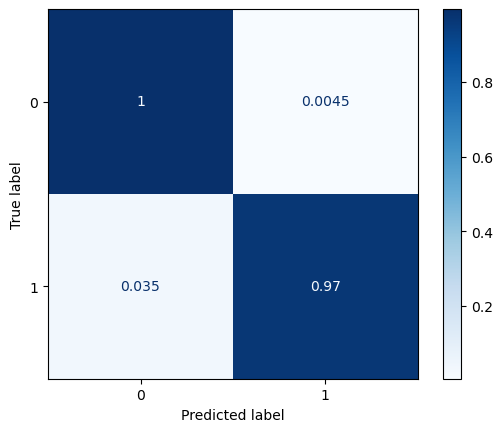

In [4]:
DOWN_TRANSFORM = torchaudio.transforms.Resample(orig_freq=400, new_freq=100)
SPLIT_SIZE=2000

def get_predictions(filepath):
    # ecog_list, label_list, ecog_downs, label_downs = read_process_mat_file(filepath)
    with h5py.File(filepath, 'r+') as f:
        label=np.array(f['rec']['SWDlabel']).reshape(-1)
        ecog=np.array(f['rec']['ecog']).reshape(-1)
        fs=np.array(f['rec']['fs'])[0][0]
        mid=np.array(f['rec']['mID'])[0][0]
        # file_name=filepath.split('/')[-1].split('.')[0]
        # scale ecog
        ecog = (ecog - np.min(ecog))/(np.max(ecog)-np.min(ecog))
    
    ecog_list=[]
    label_list=[]
    
    ecog_tensor=torch.FloatTensor(ecog).unsqueeze(0)
    label_tensor=torch.FloatTensor(label).unsqueeze(0)
    
    ecog_downs = DOWN_TRANSFORM(ecog_tensor)
    label_downs = DOWN_TRANSFORM(label_tensor)
    label_downs = torch.where(label_downs[0] > 0.5, 1, 0)
    
    ecog_list+=split_given_size(ecog_downs[0], SPLIT_SIZE)
    label_list+=split_given_size(label_downs, SPLIT_SIZE)
    
    preds, probs, testecoglist, testlabellist = predict_whole_data(model, ecog_list, label_list)
    # pred_ends=np.where(np.diff(np.sign(preds))<0)[0]
    # pred_starts=np.where(np.diff(np.sign(preds))>0)[0]
    # pred_lens=pred_ends - pred_starts
    
    # remove=(pred_lens<50)
    
    # betstarts=pred_starts[~remove]
    # betends=pred_ends[~remove]
    
    newLabels =np.zeros(len(testlabellist))
    # for i in range(len(betstarts)):
    #     newLabels[betstarts[i]:betends[i]] = 1
    
    # pred_ends=np.where(np.diff(np.sign(newLabels))<0)[0]
    # pred_starts=np.where(np.diff(np.sign(newLabels))>0)[0]
    # pred_lens=pred_ends - pred_starts

    return preds, probs, testecoglist, testlabellist


filepath='./test_data/202409_M4_MAT.mat'
preds, probs, testecoglist, testlabellist = get_predictions(filepath)
print(f"F1 Score: {f1_score(testlabellist, preds)}")
print(f"Precision Score: {precision_score(testlabellist, preds)}")
print(f"Recall Score: {recall_score(testlabellist, preds)}")
print(f"Dice Score: {1-distance.dice(testlabellist, preds)}")

# print(f"F1 Score: {f1_score(testlabellist, newLabels)}")
# print(f"Precision Score: {precision_score(testlabellist, newLabels)}")
# print(f"Recall Score: {recall_score(testlabellist, newLabels)}")
# print(f"Dice Score: {1-distance.dice(testlabellist, newLabels)}")

disp=metrics.ConfusionMatrixDisplay.from_predictions(testlabellist, preds,normalize='true',cmap='Blues')
plt.show()

## Predict from a directory containing all MICE data

- The data should be .MAT files in your directory of choice.

In [ ]:
file_dir='/project/GutIntelligenceLab/ss4yd/mice_data/unlabelled_data/NewLabelledData/'
file_paths=[os.path.join(file_dir, x) for x in os.listdir(file_dir) if 'MAT' in x]

for i, filepath in enumerate(tqdm(file_paths)):
    filename=filepath.split('/')[-1].split('.')[0]
    preds, probs, testecoglist, testlabellist = get_predictions(filepath)

    mdic={'predicted_label':preds, 'ecog':testecoglist, 'predicted_probs':probs,'actual_label':testlabellist}
    with open(f'./predictions_new_augunet1D/predicted_{filename}.mat', 'wb') as file:
        scipy.io.savemat(file, mdic, appendmat=True)
    print('\n')


    classifier_score_df = pd.DataFrame(
                                classification_report(testlabellist,
                                                     preds,
                                                     target_names=['Non-Seizure',
                                                                   'Seizure'],
                                                     digits=2,
                                                     output_dict=True))

    classifier_score_df.index.name = 'Metric'
    classifier_score_df['Classifier'] = 'AugUNet1D (ours)'
    classifier_score_df['MID'] = filename
    classifier_score_df = classifier_score_df.set_index('Classifier', append=True)

    # classifier_score_df_1s = pd.DataFrame(
    #                             classification_report(testlabellist,
    #                                                  newLabels,
    #                                                  target_names=['Non-Seizure',
    #                                                                'Seizure'],
    #                                                  digits=2,
    #                                                  output_dict=True))

    # classifier_score_df_1s.index.name = 'Metric'
    # classifier_score_df_1s['Classifier'] = 'AugUNet1D (ours)'
    # classifier_score_df_1s['MID'] = filename
    # classifier_score_df_1s = classifier_score_df_1s.set_index('Classifier', append=True)
    
    if i == 0:
        all_scores = classifier_score_df
    #     # all_scores_1s = classifier_score_df_1s
    
    else:
        all_scores = pd.concat([all_scores, classifier_score_df])
    #     # all_scores_1s = pd.concat([all_scores_1s, classifier_score_df_1s])

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/491 [00:00<?, ?it/s]

  0%|          | 0/403 [00:00<?, ?it/s]

  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/719 [00:00<?, ?it/s]

  0%|          | 0/3047 [00:00<?, ?it/s]

  0%|          | 0/3047 [00:00<?, ?it/s]

  0%|          | 0/529 [00:00<?, ?it/s]

  0%|          | 0/612 [00:00<?, ?it/s]

  0%|          | 0/1176 [00:00<?, ?it/s]

  0%|          | 0/515 [00:00<?, ?it/s]

In [ ]:
all_scores

,,Non-Seizure,Seizure,accuracy,macro avg,weighted avg,MID
Metric,Classifier,,,,,,
precision,AugUNet1D (ours),9.965019e-01,0.912713,0.991743,9.546074e-01,9.918823e-01,20240209_M3_MAT
recall,AugUNet1D (ours),9.947535e-01,0.940157,0.991743,9.674554e-01,9.917434e-01,20240209_M3_MAT
f1-score,AugUNet1D (ours),9.956270e-01,0.926232,0.991743,9.609294e-01,9.918009e-01,20240209_M3_MAT
support,AugUNet1D (ours),9.278580e+05,54142.000000,0.991743,9.820000e+05,9.820000e+05,20240209_M3_MAT
precision,AugUNet1D (ours),9.966971e-01,0.951782,0.993641,9.742394e-01,9.936505e-01,20240209_M7_MAT
recall,AugUNet1D (ours),9.964809e-01,0.954619,0.993641,9.755502e-01,9.936414e-01,20240209_M7_MAT
f1-score,AugUNet1D (ours),9.965890e-01,0.953198,0.993641,9.748937e-01,9.936458e-01,20240209_M7_MAT
support,AugUNet1D (ours),7.513290e+05,54671.000000,0.993641,8.060000e+05,8.060000e+05,20240209_M7_MAT
precision,AugUNet1D (ours),9.985033e-01,0.859340,0.991090,9.289219e-01,9.919354e-01,20240209_M4_MAT


In [ ]:
# all_scores.to_csv('./augunet1D_results_v3.csv')

In [ ]:
!nvidia-smi

Mon Dec  8 12:53:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               Off |   00000000:81:00.0 Off |                  Off |
| 43%   70C    P0            297W /  300W |    2362MiB /  49140MiB |    100%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----